<img src="mrc.png" alt="Description de l'image" width="1400" height="100">

## <span style="color: red;">Chilhood Tuberculosis Study </span>

### <span style="color: red;">Data Cleaning </span>

####  Data cleaning steps performed

- Standardized column names using `clean_names()`.
- Renamed columns for better readability and clarity.
- Dropped irrelevant or unnecessary columns.
- Cleaned textual values:
  - Standardized to lowercase and removed extra spaces/special characters.
  - Replaced missing values (`n/a`, `?`, `unknown`, etc.) with `NaN`.
  - Parsed valid date strings to the `YYYY-MM-DD` format.
- Created a new `country` variable extracted from patient IDs.
- Created an `age` variable based on date of birth and participation date.
- Removed duplicate rows based on patient ID.
- Inspected missing values (count and proportion per variable).
- Saved the cleaned dataset to a new CSV file 


#### <span style="color: red;"> Load packages</span>

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import seaborn as sns  
import missingno as msn   
import janitor
import re     
from dateutil import parser
# Install local package using "pip install -e . --config-setting editable_mode=compat"
import src  
from src.clean import load_data_and_dict       
from collections import Counter
import os
from dotenv import load_dotenv

#### <span style="color: red;">Load the dataset</span>

In [2]:
# Load the west africa data 
load_dotenv() 

sheets = pd.read_excel(os.getenv('TBDATA_FILE_PATH'), sheet_name=None)

# Define the variable names in the order of sheets
df_names = ["presumed_tb_data", "r4ka_gambia_tb_data", "combo_tb_data", "chirwa_gambia_tb_data"]

# Assign each sheet by index
for i, df_name in enumerate(df_names):
    globals()[df_name] = list(sheets.values())[i]

df= pd.read_csv(os.getenv('CHTBDATA_FILE_PATH'))

dict= pd.read_csv(os.getenv('DATA_DICT_FILE_PATH'))

**The  dataset contains 228 rows, representing the number of observations, and  82  columns, representing the number of variables.**

####  <span style="color: red;">Variable information</span>

In [3]:
# Varible description
descrip = dict[["Variable / Field Name", "Field Type", "Field Label"]]

# save as a csv file
descrip.to_csv('dict.csv', index=False)

#display(descrip)

####  <span style="color: red;"> Fisrt few rows of the dataset</span>

In [4]:
# First 5 rows of the dataset
display(df.head())

,q1_pre_tb,redcap_data_access_group,q1a_pre_tb,q2_pre_tb,q3_pre_tb,q4_pre_tb,q4a_pre_tb,q4b_pre_tb,q4c_pre_tb,q5_pre_tb,...,q59_pre_tb,q60_pre_tb,q61_pre_tb,q62_pre_tb,q63_pre_tb,q64_pre_tb,q65_pre_tb,q66_pre_tb,appuser,presumed_tb_form_complete
0,BEN001,dc_benin,1/2020,2020-05-05,AH,0.0,NaN,NaN,NaN,1.0,...,NaN,NaN,4.0,0.0,3.0,no,pneumonia,0.0,afiogbe,2
1,BEN003,dc_benin,NaN,2020-04-28,IS,0.0,NaN,NaN,NaN,1.0,...,NaN,NaN,2.0,1.0,3.0,no EPTB,lymphoma,0.0,afiogbe,2
2,BEN004,dc_benin,NaN,2020-04-30,MA,0.0,NaN,NaN,NaN,1.0,...,NaN,NaN,4.0,0.0,3.0,an acute community pneumonia,NaN,0.0,afiogbe,2
3,BEN005,dc_benin,NaN,2020-05-06,KC,0.0,NaN,NaN,NaN,1.0,...,NaN,NaN,4.0,1.0,3.0,NaN,pneumocystis,0.0,afiogbe,2
4,BEN0059,dc_benin,NaN,2021-03-18,AA,0.0,NaN,NaN,NaN,1.0,...,NaN,NaN,4.0,2.0,3.0,not an EPTB,other pneumonia,0.0,afiogbe,2


####  <span style="color: red;">Age calculation based on multiple columns</span>

In [5]:
# Age calculation
def compute_age(row):
    if pd.notnull(row['q4b_pre_tb']):
        return row['q4b_pre_tb']
    elif pd.notnull(row['q6_pre_tb']):
        return row['q6_pre_tb']
    elif pd.notnull(row['q4c_pre_tb']):
        return round(row['q4c_pre_tb'] / 12, 2)
    elif pd.notnull(row['q5b_pre_tb']):
        return round(row['q5b_pre_tb'] / 12, 2)
    else:
        return None

df['Age'] = df.apply(compute_age, axis=1)

####  <spanA style="color: red;"> Data cleaning pipeline </span>

In [6]:
# Cleaning function
def clean_column(val):
    if pd.isna(val):
        return val
    val = str(val).strip()
    
    # Detect and normalize valid date strings
    try:
        parsed_date = parser.parse(val, fuzzy=False)
        return parsed_date.strftime('%Y-%m-%d')
    except (ValueError, TypeError):
        pass  

    val = val.lower()
    
    # Replace invalid or missing values
    if re.match(r"^\s*$|^_+$|^(n/a|na|null|none|unknown|\?)$", val, re.IGNORECASE):
        return pd.NA

    # Normalize text values
    val = re.sub(r"\s+", "_", val)         
    val = re.sub(r"[^a-zA-Z0-9_]", "", val)  
    return val

# Cleaning pipeline
df = (
    df
    .clean_names()
    .apply(lambda col: col.map(clean_column) if col.dtype == "object" else col)
    .drop_duplicates(subset='q1_pre_tb')
)

display(df.head())

,q1_pre_tb,redcap_data_access_group,q1a_pre_tb,q2_pre_tb,q3_pre_tb,q4_pre_tb,q4a_pre_tb,q4b_pre_tb,q4c_pre_tb,q5_pre_tb,...,q60_pre_tb,q61_pre_tb,q62_pre_tb,q63_pre_tb,q64_pre_tb,q65_pre_tb,q66_pre_tb,appuser,presumed_tb_form_complete,age
0,ben001,dc_benin,2020-01-10,2020-05-05,ah,0.0,NaN,NaN,NaN,1.0,...,NaN,4.0,0.0,3.0,no,pneumonia,0.0,afiogbe,2,0.67
1,ben003,dc_benin,NaN,2020-04-28,is,0.0,NaN,NaN,NaN,1.0,...,NaN,2.0,1.0,3.0,no_eptb,lymphoma,0.0,afiogbe,2,14.00
2,ben004,dc_benin,NaN,2020-04-30,ma,0.0,NaN,NaN,NaN,1.0,...,NaN,4.0,0.0,3.0,an_acute_community_pneumonia,NaN,0.0,afiogbe,2,14.00
3,ben005,dc_benin,NaN,2020-05-06,kc,0.0,NaN,NaN,NaN,1.0,...,NaN,4.0,1.0,3.0,NaN,pneumocystis,0.0,afiogbe,2,2.42
4,ben0059,dc_benin,NaN,2021-03-18,aa,0.0,NaN,NaN,NaN,1.0,...,NaN,4.0,2.0,3.0,not_an_eptb,other_pneumonia,0.0,afiogbe,2,5.00


####  <span style="color: red;"> Extract country from patient identifier </span>

In [7]:
# Function to map patient ID to country
def map_country_from_id(val):
    val = val.lower()
    if val.startswith('ben'):
        return 'Benin'
    elif val.startswith('gh'):
        return 'Ghana'
    elif val.startswith('mal'):
        return 'Mali'
    elif val.startswith(('ngjo', 'njjo', 'uchng')):
        return 'Nigeria'
    else:
        return 'Unknown'

In [8]:
# Apply the function 
df['country'] = df['q1_pre_tb'].astype(str).apply(map_country_from_id)

# Number of patients per country
country_counts = df['country'].value_counts()
print(country_counts)

country
Mali       70
Benin      66
Ghana      66
Nigeria    26
Name: count, dtype: int64


####  <span style="color: red;"> Exclude non-analytical columns</span>

In [9]:
# Drop the specified columns
df = df.drop(columns=["q1a_pre_tb", "q3_pre_tb", "q4_pre_tb", "q4a_pre_tb", "q4b_pre_tb", "q4c_pre_tb", 
                      "q5_pre_tb", "q5b_pre_tb", "q6_pre_tb",  "redcap_data_access_group", "appuser", 
                      "q32_pre_tb", "q33_pre_tb", "q34_pre_tb", "q35_pre_tb", "q36_pre_tb", "q44_pre_tb",
                      "q50_pre_tb", "q58_pre_tb", "presumed_tb_form_complete", "q46_pre_tb", "q47_pre_tb",
                      "q48_pre_tb", "q53_pre_tb", "q59_pre_tb", "q60_pre_tb", "q56_pre_tb"])

####  <span style="color: red;"> Rename columns for clarity and analysis</span>

In [10]:
# Define the columns to keep with their new names 
new_names = {
    # Demographic data
    'q1_pre_tb': 'patient_id', 
    'q_age_pre_tb': 'age', 
    'q2_pre_tb': 'regist_date',
    'q7_pre_tb': 'gender',
    'q1_pre_tb_country': 'country',

    # Clinical conditions
    'q8_pre_tb': 'cough',
    'q9_pre_tb': 'productive', 
    'q10_pre_tb': 'chest_pain',
    'q11_pre_tb': 'wheeze', 
    'q12_pre_tb': 'fever_chills',
    'q13_pre_tb': 'loss_weight', 
    'q14_pre_tb': 'difficulty_breathing',
    'q15_pre_tb': 'night_sweats', 
    'q16_pre_tb': 'side_pain',
    'q17_pre_tb': 'malaise_fatigue', 
    'q18_pre_tb': 'loss_appetite',
    'q19_pre_tb': 'haemoptysis', 
    'q20_pre_tb': 'vomiting',
    'q21_pre_tb': 'previous_tb', 
    'q22_pre_tb': 'date_previous_tb',

    #clinical signs
    'q23_pre_tb': 'pallor', 
    'q24_pre_tb': 'splenomegaly',
    'q25_pre_tb': 'jaundice', 
    'q26_pre_tb': 'hepatomegaly',
    'q27_pre_tb': 'wasting', 
    'q28_pre_tb': 'dyspnoea',
    'q29_pre_tb': 'lethargy', 
    'q30_pre_tb': 'abd_distension_mass',
    'q31_pre_tb': 'neck_lymph', 
    'q32b_pre_tb': 'temperature',
    'q33b_pre_tb': 'weight', 
    'q34b_pre_tb': 'height',
    'q35b_pre_tb': 'mua_circumference', 
    'q36a_pre_tb': 'other_clinical_sign',

    # Chest Estimation
    'q37_pre_tb': 'respiratory_rate', 
    'q38_pre_tb': 'subscostal_rec',
    'q39_pre_tb': 'dullness', 
    'q40_pre_tb': 'crepitation',
    'q41_pre_tb': 'bronchial_breathing', 
    'q42_pre_tb': 'rhonchi',
    'q43_pre_tb': 'reduced_breath_sounds', 
    'q44a_pre_tb': 'other_abnorm',
    'q45_pre_tb': 'abnorm_site', 
    
    # chest x-ray
    #'q46_pre_tb':'cxr_done',
    #'q47_pre_tb':'cxr_date',
    #'q48_pre_tb':'cxr_quality',
    'q49_pre_tb':'xray_assessment',
    'q50a_pre_tb':'other_xray',

    # sample collection
    #'q51_pre_tb':'specimen_type',
    'q52_pre_tb':'specimen_result',
    #'q53_pre_tb':'spec_date',
    'q54_pre_tb':'sputum_type',
    'q55_pre_tb':'genexpert_result',
    'q57_pre_tb':'mgit_result',
    'q58a_pre_tb':'other_mycobacteria',
    #'q59_pre_tb':'data_when_positive',
    #'q60_pre_tb':'time_when_positive',
    'q61_pre_tb':'histology_result',
    'q62_pre_tb':'hiv_serology',

    # Conclusion
    'q63_pre_tb': 'diagnosis',
    'q64_pre_tb':'eptb_site',
    'q65_pre_tb':'nottb_diagnosis',
    'q66_pre_tb':'antitb_treatment',
}

# Rename the columns
df = df.rename(columns=new_names)

# Select only the renamed columns
df = df[list(new_names.values())]

# Display the names of the kept columns
print(df.columns)

Index(['patient_id', 'age', 'regist_date', 'gender', 'country', 'cough',
       'productive', 'chest_pain', 'wheeze', 'fever_chills', 'loss_weight',
       'difficulty_breathing', 'night_sweats', 'side_pain', 'malaise_fatigue',
       'loss_appetite', 'haemoptysis', 'vomiting', 'previous_tb',
       'date_previous_tb', 'pallor', 'splenomegaly', 'jaundice',
       'hepatomegaly', 'wasting', 'dyspnoea', 'lethargy',
       'abd_distension_mass', 'neck_lymph', 'temperature', 'weight', 'height',
       'mua_circumference', 'other_clinical_sign', 'respiratory_rate',
       'subscostal_rec', 'dullness', 'crepitation', 'bronchial_breathing',
       'rhonchi', 'reduced_breath_sounds', 'other_abnorm', 'abnorm_site',
       'xray_assessment', 'other_xray', 'specimen_result', 'sputum_type',
       'genexpert_result', 'mgit_result', 'other_mycobacteria',
       'histology_result', 'hiv_serology', 'diagnosis', 'eptb_site',
       'nottb_diagnosis', 'antitb_treatment'],
      dtype='object')


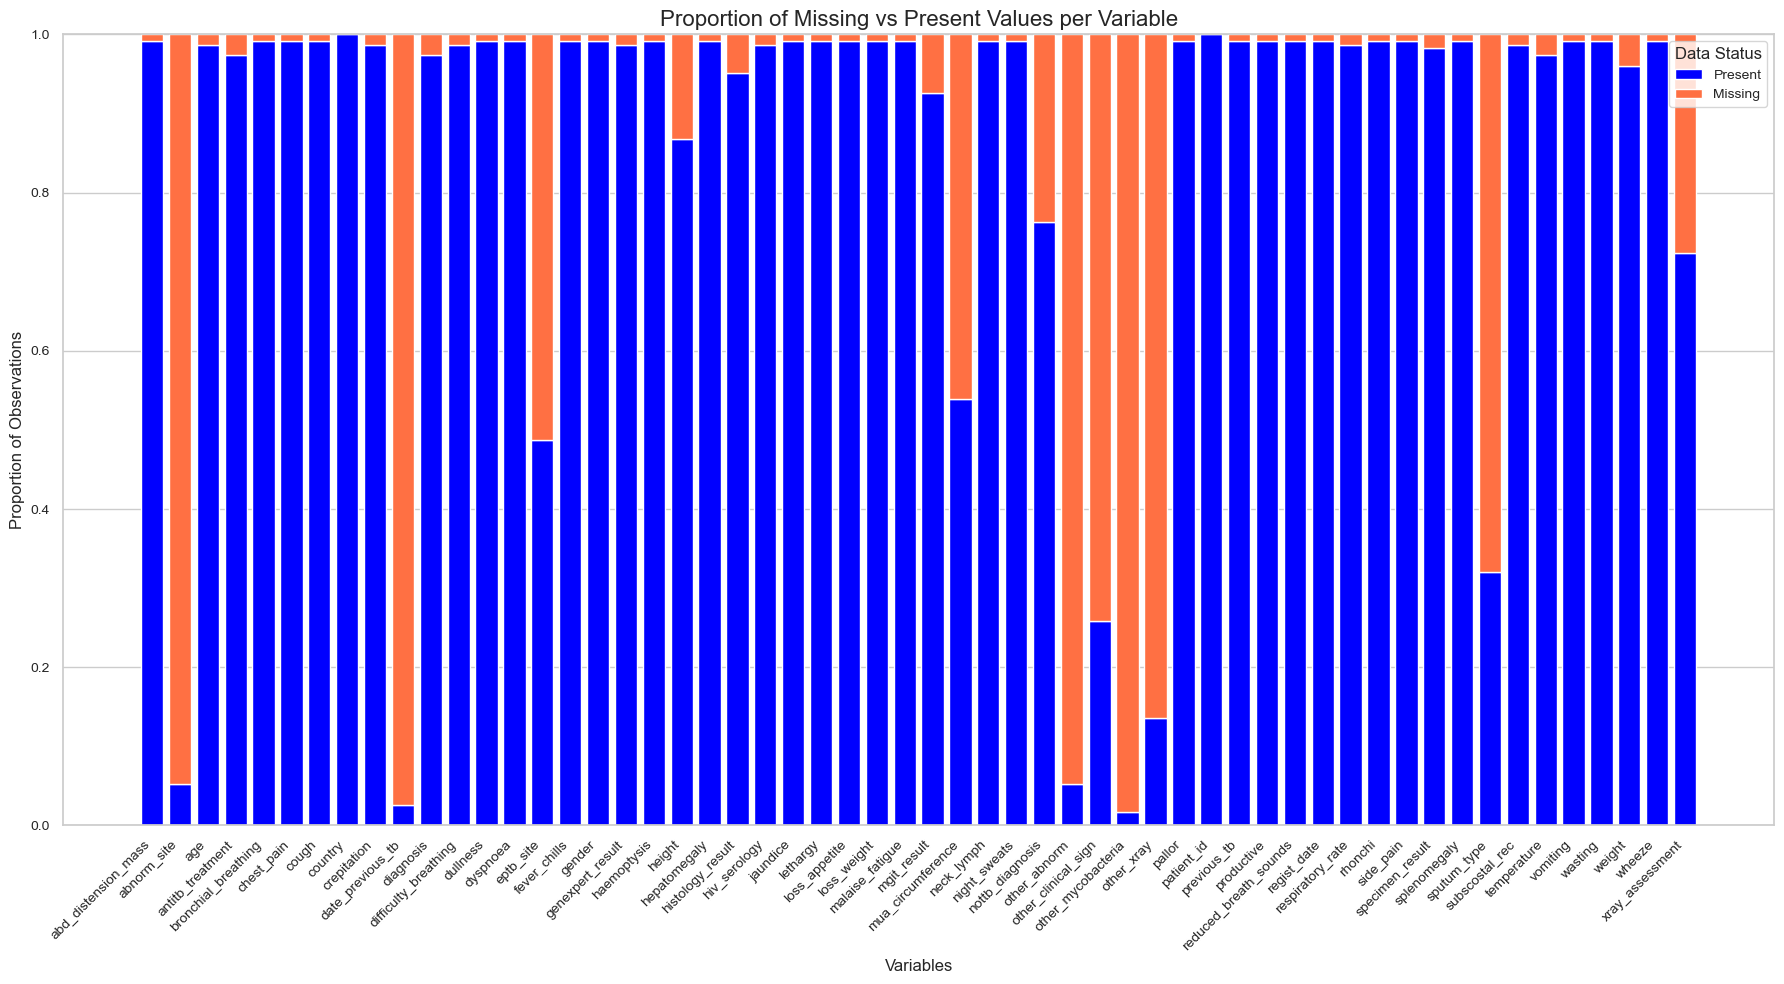

In [11]:
# Total number of rows
n = len(df)

# Calculate proportion of missing and present values
proportion_df = pd.DataFrame({
    'Variable': df.columns,
    'Missing': df.isnull().sum().values / n,
    'Present': df.notnull().sum().values / n
})

# Convert to long format
df_long = proportion_df.melt(id_vars='Variable', 
                             value_vars=['Present', 'Missing'],
                             var_name='Status', value_name='Proportion')

# Plot
plt.figure(figsize=(18, 10))
sns.set(style="whitegrid")

# Stacked vertical bars: first present, then missing on top
# Create a pivot table to compute stacked bars manually
pivot = df_long.pivot(index='Variable', columns='Status', values='Proportion').fillna(0)
bottom = pivot['Present']

# Plot present values
plt.bar(pivot.index, pivot['Present'], color='blue', label='Present')

# Plot missing values
plt.bar(pivot.index, pivot['Missing'], bottom=bottom, color='#FF7043', label='Missing')

# Aesthetics
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Proportion of Observations', fontsize=12)
plt.xlabel('Variables', fontsize=12)
plt.title('Proportion of Missing vs Present Values per Variable', fontsize=16)
plt.legend(title='Data Status', fontsize=10, loc='upper right')
plt.tight_layout()
plt.show()

####  <span style="color: red;"> Removing columns with high percentage of missing values</span>

In [12]:
# Drop missing values in 'diagnosis'
df = df.dropna(subset=['diagnosis'])

# Percentage of missing values for each column.
missing_percentages = df.isnull().sum() / len(df) * 100

# Columns with more than 70% missing values.
columns_to_drop = missing_percentages[missing_percentages > 20].index

# Drop these columns from the DataFrame in place.
df.drop(columns=columns_to_drop, inplace=True)

#### <span style="color: red;">Missing data overview</span>

In [13]:
# Inspect Missing Values
missing_values = df.isnull().sum()
missing_proportions = missing_values / len(df )
missing_df = pd.concat([missing_values, missing_proportions], axis=1)

missing_df.columns = ['Number of Missing Values', 'Proportion of Missing Values']
missing_df = missing_df.sort_values('Proportion of Missing Values', ascending=False)

display(missing_df)

,Number of Missing Values,Proportion of Missing Values
height,27,0.121622
mgit_result,11,0.049550
weight,7,0.031532
histology_result,5,0.022523
temperature,3,0.013514
subscostal_rec,1,0.004505
regist_date,1,0.004505
gender,1,0.004505
age,1,0.004505
hiv_serology,1,0.004505



####  <span style="color: red;"> Handling missing values in selected variables</span>

In [14]:
# Function to impute missing values  
def impute_missing(df, median_cols, mode_cols):
    for col in median_cols:
        df[col] = df[col].fillna(df[col].median())
    for col in mode_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    return df

# Define columns
median_cols = ['height', 'weight', 'temperature', 'age', 'respiratory_rate']
mode_cols = ['gender', 'subscostal_rec', 'crepitation', 'difficulty_breathing',
             'mgit_result', 'histology_result', 'hiv_serology', 'regist_date']

# Apply imputation
df = impute_missing(df, median_cols, mode_cols)

# Check for remaining missing values
display(df.isnull().sum())

patient_id               0
age                      0
regist_date              0
gender                   0
country                  0
cough                    0
productive               0
chest_pain               0
wheeze                   0
fever_chills             0
loss_weight              0
difficulty_breathing     0
night_sweats             0
side_pain                0
malaise_fatigue          0
loss_appetite            0
haemoptysis              0
vomiting                 0
previous_tb              0
pallor                   0
splenomegaly             0
jaundice                 0
hepatomegaly             0
wasting                  0
dyspnoea                 0
lethargy                 0
abd_distension_mass      0
neck_lymph               0
temperature              0
weight                   0
height                   0
respiratory_rate         0
subscostal_rec           0
dullness                 0
crepitation              0
bronchial_breathing      0
rhonchi                  0
r

####  <span style="color: red;"> Save the cleaned dataset to a new CSV file</span>

In [15]:
# Save the cleaned dataset to a new CSV file
df.to_csv('cleaned_tb_dataset.csv', index=False)

In [16]:
df.columns

Index(['patient_id', 'age', 'regist_date', 'gender', 'country', 'cough',
       'productive', 'chest_pain', 'wheeze', 'fever_chills', 'loss_weight',
       'difficulty_breathing', 'night_sweats', 'side_pain', 'malaise_fatigue',
       'loss_appetite', 'haemoptysis', 'vomiting', 'previous_tb', 'pallor',
       'splenomegaly', 'jaundice', 'hepatomegaly', 'wasting', 'dyspnoea',
       'lethargy', 'abd_distension_mass', 'neck_lymph', 'temperature',
       'weight', 'height', 'respiratory_rate', 'subscostal_rec', 'dullness',
       'crepitation', 'bronchial_breathing', 'rhonchi',
       'reduced_breath_sounds', 'specimen_result', 'genexpert_result',
       'mgit_result', 'histology_result', 'hiv_serology', 'diagnosis',
       'antitb_treatment'],
      dtype='object')